# Icosphere Properties

Let's investigate the geometric properties of the icosphere to get a good understanding of how closely it approximates a sphere.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import jax.numpy as jnp
import astropy.units as u
import astropy.constants as const
from IPython.display import display

%matplotlib inline

# Ensure the project root is on the Python path so 'spice' is importable
# The spice package lives in src/spice/, so we add src/ to the path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
from spice.models.mesh_model import IcosphereModel

from jax.typing import ArrayLike
import jax.numpy as jnp
import jax

from typing import List, Optional, Union
from collections import namedtuple
import warnings

from spice.models.mesh_generation import icosphere
from spice.models.utils import calculate_axis_radii

from jaxtyping import Array, Float, Union
import jax

In [2]:
from spice.models.mesh_model import (DEFAULT_FOURIER_ORDER, DEFAULT_LOS_VECTOR,
                                     DEFAULT_MAX_PULSATION_MODE_PARAMETER, DEFAULT_ROTATION_AXIS,
                                     LOG_G_NAMES, NO_ROTATION_MATRIX, MeshModel, calculate_log_gs,
                                     create_harmonics_params)
from spice.models.utils import float_dtype


def construct_no_scaling(n_vertices: int,
                         radius: float,
                         mass: float,
                        parameters: Union[float, Float[Array, "n_mesh_elements n_parameters"]],
                        parameter_names: List[str],
                        max_pulsation_mode: int = DEFAULT_MAX_PULSATION_MODE_PARAMETER,
                        max_fourier_order: int = DEFAULT_FOURIER_ORDER,
                        override_log_g: bool = True,
                        log_g_index: Optional[int] = None) -> "IcosphereModel":
    vertices, faces, areas, centers = icosphere(n_vertices)
    vertices = vertices * radius
    centers = centers * radius

    parameters = jnp.atleast_1d(parameters)
    if len(parameters.shape) == 1:
        parameters = jnp.repeat(parameters[jnp.newaxis, :], repeats=areas.shape[0], axis=0)
    if override_log_g:
        if any([pn in parameter_names for pn in LOG_G_NAMES]):
            log_g_index = [i for i, pn in enumerate(parameter_names) if pn in LOG_G_NAMES][0]
            parameters = parameters.at[:, log_g_index].set(calculate_log_gs(mass, centers * radius))
        elif log_g_index and isinstance(log_g_index, int):
            parameters = parameters.at[:, log_g_index].set(calculate_log_gs(mass, centers * radius))
        else:
            warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
                LOG_G_NAMES) + "], or log_g_index must be passed for log g to be used in the spectrum emulator.")

    harmonics_params = create_harmonics_params(max_pulsation_mode)
    
    if len(parameter_names) != parameters.shape[1]:
        raise ValueError("parameter_names must have the same length as the number of parameters.")

    return MeshModel.__new__(MeshModel, 0.,
                                radius,
                                mass,
                                d_vertices=vertices,
                                faces=faces,
                                d_centers=centers,
                                base_areas=areas,
                                parameters=parameters,
                                log_g_index=log_g_index,
                                rotation_velocities=jnp.zeros_like(centers, dtype=float_dtype),
                                vertices_pulsation_offsets=jnp.zeros_like(vertices, dtype=float_dtype),
                                center_pulsation_offsets=jnp.zeros_like(centers, dtype=float_dtype),
                                area_pulsation_offsets=jnp.zeros_like(areas, dtype=float_dtype),
                                pulsation_velocities=jnp.zeros_like(centers, dtype=float_dtype),
                                rotation_axis=DEFAULT_ROTATION_AXIS,
                                rotation_matrix=NO_ROTATION_MATRIX,
                                rotation_matrix_prim=NO_ROTATION_MATRIX,
                                axis_radii=calculate_axis_radii(centers, DEFAULT_ROTATION_AXIS),
                                rotation_velocity=0.,
                                orbital_velocity=0.,
                                occluded_areas=jnp.zeros_like(areas, dtype=float_dtype),
                                los_vector=DEFAULT_LOS_VECTOR,
                                max_pulsation_mode=max_pulsation_mode,
                                max_fourier_order=max_fourier_order,
                                spherical_harmonics_parameters=harmonics_params,
                                pulsation_periods=jnp.nan * jnp.ones(harmonics_params.shape[0], dtype=float_dtype),
                                # D_0 (amplitude), period
                                fourier_series_parameters=jnp.nan * jnp.ones(
                                    (harmonics_params.shape[0], max_fourier_order, 2), dtype=float_dtype), # D_n, phi_n
                                pulsation_axes=DEFAULT_ROTATION_AXIS.reshape((1, 3)).repeat(harmonics_params.shape[0], axis=0),
                                pulsation_angles=jnp.zeros((harmonics_params.shape[0], 1), dtype=float_dtype))

In [3]:
def approximate_mesh_volume(vertices, faces):
    triangles = np.asarray(vertices)[np.asarray(faces, dtype=np.int32)]
    v0 = triangles[:, 0, :]
    v1 = triangles[:, 1, :]
    v2 = triangles[:, 2, :]
    signed_tetra_volumes = np.einsum('ij,ij->i', v0, np.cross(v1, v2)) / 6.0
    return np.abs(np.sum(signed_tetra_volumes))


def values_for_icosphere(n_vertices: int, radius: float, scaling: bool = True):
    # Create an IcosphereModel
    radius = 1.0  # Solar radii
    mass = 1.0    # Solar masses
    parameters = jnp.ones(1)  # Simple parameter array
    parameter_names = ["teff"]  # Parameter name

    if scaling:
        # Construct the model
        icosphere_model = IcosphereModel.construct(
            n_vertices=n_vertices,
            radius=radius,
            mass=mass,
            parameters=parameters,
            parameter_names=parameter_names,
            override_log_g=False
        )
    else:
        icosphere_model = construct_no_scaling(
            n_vertices=n_vertices,
            radius=radius,
            mass=mass,
            parameters=parameters,
            parameter_names=parameter_names,
            override_log_g=False
        )

    sun_surface_area = 4 * np.pi * (radius * u.R_sun.to(u.m))**2
    icosphere_surface_area = np.sum(icosphere_model.areas) * (radius * u.R_sun.to(u.m))**2

    sun_volume = 4.0 / 3.0 * np.pi * (radius * u.R_sun.to(u.m))**3
    mesh_volume = approximate_mesh_volume(icosphere_model.d_vertices, icosphere_model.faces)
    mesh_volume_m3 = mesh_volume * (u.R_sun.to(u.m))**3

    return (
        len(icosphere_model.radii),
        np.mean(icosphere_model.radii) / radius,
        icosphere_surface_area / sun_surface_area,
        mesh_volume_m3 / sun_volume,
    )

In [4]:
# Test with different numbers of vertices
vertex_counts = [100, 1000, 2000, 10000]
results_w_scaling = []
results_no_scaling = []

for n_vertices in vertex_counts:
    vertices_count, mean_radius_ratio, surface_area_ratio, volume_ratio = values_for_icosphere(n_vertices, 1.0)
    results_w_scaling.append((vertices_count, mean_radius_ratio, surface_area_ratio, volume_ratio))
    vertices_count_no_scaling, mean_radius_ratio_no_scaling, surface_area_ratio_no_scaling, volume_ratio_no_scaling = values_for_icosphere(n_vertices, 1.0, scaling=False)
    results_no_scaling.append((vertices_count_no_scaling, mean_radius_ratio_no_scaling, surface_area_ratio_no_scaling, volume_ratio_no_scaling))
    print(
        f"Vertices: {vertices_count}, Mean Radius Ratio: {mean_radius_ratio:.6f}, No Scaling: {mean_radius_ratio_no_scaling:.6f} "
        f"Surface Area Ratio: {surface_area_ratio:.6f}, Volume Ratio: {volume_ratio:.6f}, No Scaling: {volume_ratio_no_scaling:.6f}"
    )


Vertices: 320, Mean Radius Ratio: 0.996256, No Scaling: 0.984890 Surface Area Ratio: 1.003957, Volume Ratio: 1.000000, No Scaling: 0.966161
Vertices: 1280, Mean Radius Ratio: 0.999064, No Scaling: 0.996190 Surface Area Ratio: 1.000986, Volume Ratio: 1.000000, No Scaling: 0.991394
Vertices: 5120, Mean Radius Ratio: 0.999766, No Scaling: 0.999045 Surface Area Ratio: 1.000247, Volume Ratio: 1.000000, No Scaling: 0.997839
Vertices: 20480, Mean Radius Ratio: 0.999941, No Scaling: 0.999761 Surface Area Ratio: 1.000062, Volume Ratio: 1.000000, No Scaling: 0.999459


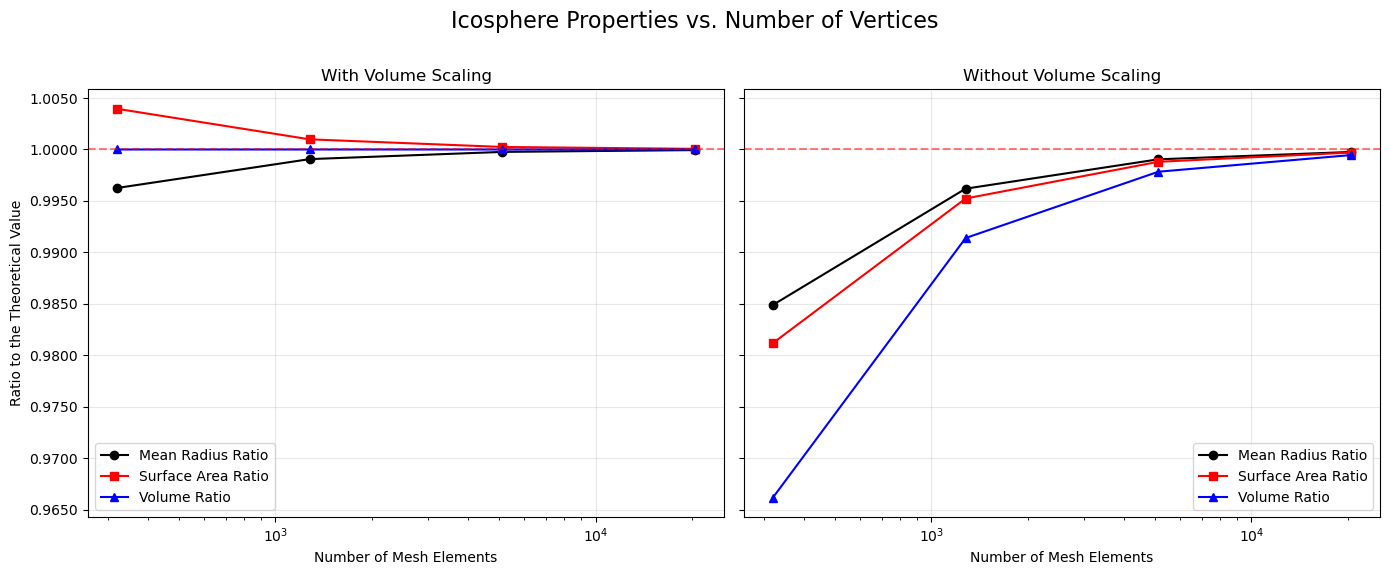

In [6]:
# Extract data for plotting: with scaling
vertices_w_scaling = [r[0] for r in results_w_scaling]
mean_radius_ratios_w_scaling = [r[1] for r in results_w_scaling]
surface_area_ratios_w_scaling = [r[2] for r in results_w_scaling]
volume_ratios_w_scaling = [r[3] for r in results_w_scaling]

# Extract data for plotting: no scaling
vertices_no_scaling = [r[0] for r in results_no_scaling]
mean_radius_ratios_no_scaling = [r[1] for r in results_no_scaling]
surface_area_ratios_no_scaling = [r[2] for r in results_no_scaling]
volume_ratios_no_scaling = [r[3] for r in results_no_scaling]

# Create a double pane figure (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# With scaling
ax = axes[0]
ax.plot(vertices_w_scaling, mean_radius_ratios_w_scaling, 'o-', color='black', label='Mean Radius Ratio')
ax.plot(vertices_w_scaling, surface_area_ratios_w_scaling, 's-', color='red', label='Surface Area Ratio')
ax.plot(vertices_w_scaling, volume_ratios_w_scaling, '^-', color='blue', label='Volume Ratio')
ax.set_xlabel('Number of Mesh Elements')
ax.set_ylabel('Ratio to the Theoretical Value')
ax.set_xscale('log')
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)
ax.set_title('With Volume Scaling')
ax.legend(loc='best')

# Without scaling
ax = axes[1]
ax.plot(vertices_no_scaling, mean_radius_ratios_no_scaling, 'o-', color='black', label='Mean Radius Ratio')
ax.plot(vertices_no_scaling, surface_area_ratios_no_scaling, 's-', color='red', label='Surface Area Ratio')
ax.plot(vertices_no_scaling, volume_ratios_no_scaling, '^-', color='blue', label='Volume Ratio')
ax.set_xlabel('Number of Mesh Elements')
ax.set_xscale('log')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)
ax.set_title('Without Volume Scaling')
ax.legend(loc='best')

fig.suptitle('Icosphere Properties vs. Number of Vertices', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('../img/icosphere_properties.png', dpi=300)

display(fig)